In [1]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

In [2]:
from load_librairies import *
from scipy.stats.stats import pearsonr
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy

def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x
    return y_detrended


def is_mjj(month):
    return (month>=5) & (month<=7)

def is_mam(month):
    return (month>=3) & (month<=5)

def is_jja(month):
    return (month>=6) & (month<=8)

def is_nd(month):
    return (month==11) | (month==12)


dir_proj = '/home/netapp-clima-users/users/aprigent/Projects/TAV_OMIP/'
path_fig = dir_proj+'/figures_final/'
path_data_out = '/media/aprigent/Arthur_disk/data_uncertainty/'


dir_tos_omip1 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/'
dir_tos_omip2 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/'
dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/'

period_str = 1985
period_end = 2004
%matplotlib inline



/tmp/ipykernel_3728/4264991606.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# ORA-S5

In [3]:

sst_oras5_tmp = xr.open_dataset(dir_obs_sst+'ORA-S5/sosstsst_merged_r360x180_oras5_1960_2005.nc')
sst_oras5_tmp = sst_oras5_tmp.sosstsst[:] # K to degC
sst_oras5 = sst_oras5_tmp.sel(time_counter=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
sst_oras5_arr = np.array(sst_oras5)
sst_oras5_atl_dtd = np.ones((sst_oras5_arr.shape))*np.nan
for i in range(sst_oras5_atl_dtd.shape[1]):
    for j in range(sst_oras5_atl_dtd.shape[2]):
        sst_oras5_atl_dtd[:,i,j] = nandetrend(sst_oras5_arr[:,i,j])
        
        
sst_oras5_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_oras5_atl_dtd)}
                       ,coords={'time':np.array(sst_oras5.time_counter),
                                'lon':np.array(sst_oras5.lon),
                                'lat':np.array(sst_oras5.lat)
                                })
        
sst_oras5_atl3 = Atools.data_sub(sst_oras5_atl_dtd_xarray,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(sst_oras5_atl_dtd_xarray,-20,0,-3,3).lat))).mean(('lon','lat'))
ssta_oras5_atl3_dtd,_ = Atools.ano_norm_t(sst_oras5_atl3.sst_dtd)
ssta_oras5_atl3_dtd_mjj = ssta_oras5_atl3_dtd.sel(time=is_mjj(
    ssta_oras5_atl3_dtd['time.month'])).groupby('time.year').mean()
std_ssta_oras5_atl3_dtd_mjj = ssta_oras5_atl3_dtd_mjj.std(dim='year')

In [4]:
ssta_oras5_atl_dtd,_ = Atools.ano_norm_t(sst_oras5_atl_dtd_xarray.sst_dtd)

ssta_oras5_atl_dtd_mjj = ssta_oras5_atl_dtd.sel(time=is_mjj(
    ssta_oras5_atl_dtd['time.month'])).groupby('time.year').mean()

std_ssta_oras5_atl_dtd_mjj = ssta_oras5_atl_dtd_mjj.std(dim='year')


# OMIP models

In [7]:
omip1_models = pd.read_csv(dir_proj+'/scripts/omip1_models_for_BF_zos.txt',header=None,delimiter=',')
omip1_models = omip1_models[0].values.tolist()
print(omip1_models)


omip2_models = pd.read_csv(dir_proj+'/scripts/omip2_models_for_BF_zos.txt',header=None,delimiter=',')
omip2_models = omip2_models[0].values.tolist()
print(omip2_models)

['CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']
['ACCESS-OM2', 'ACCESS-OM2-025', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3', 'MRI-ESM2-0', 'NorESM2-LM']


In [8]:
def get_sst_omip1_atl(directory,model):
    print(directory+model+'/r1i1p1f1/ATL/*.nc')
    sst_omip1 = xr.open_dataset(
        directory+model+'/r1i1p1f1/ATL/tos_merged_standard_'+str(model)+'_r360x180_atl.nc',use_cftime=True)
    print(sst_omip1.tos.shape)
    sst_omip1 = sst_omip1.tos[4*744:5*744,:,:]
    print(sst_omip1.time)
    time_new = pd.date_range('1948-01-15', freq='M',periods=sst_omip1.time.shape[0])
    sst_omip1['time'] = time_new
    sst_omip1 = sst_omip1.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
    
    sst_omip1_atl = Atools.data_sub(sst_omip1,-45,20,-30,10)
    sst_omip1_atl_arr = np.array(sst_omip1_atl)
    sst_omip1_atl_dtd = np.ones((sst_omip1_atl_arr.shape))*np.nan
    for i in range(sst_omip1_atl.shape[1]):
        for j in range(sst_omip1_atl.shape[2]):
            sst_omip1_atl_dtd[:,i,j] = nandetrend(sst_omip1_atl_arr[:,i,j])
             

    sst_omip1_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_omip1_atl_dtd)}
                       ,coords={'time':np.array(sst_omip1_atl.time),
                                'lon':np.array(sst_omip1_atl.lon),
                                'lat':np.array(sst_omip1_atl.lat)
                                })
    
    
    ssta_omip1_atl_dtd,_ = Atools.ano_norm_t(sst_omip1_atl_dtd_xarray.sst_dtd)

    return ssta_omip1_atl_dtd,sst_omip1_atl_dtd_xarray.sst_dtd


def get_sst_omip2_atl(directory,model):
    print(directory+model+'/r1i1p1f1/ATL/*.nc')
    sst_omip1 = xr.open_dataset(
        directory+model+'/r1i1p1f1/ATL/tos_merged_standard_'+str(model)+'_r360x180_atl.nc',use_cftime=True)
    print(sst_omip1.tos.shape)
    sst_omip1 = sst_omip1.tos[5*732:6*732,:,:]
    time_new = pd.date_range('1958-01-15', freq='M',periods=sst_omip1.time.shape[0])
    sst_omip1['time'] = time_new
    sst_omip1 = sst_omip1.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
    
    sst_omip1_atl = Atools.data_sub(sst_omip1,-45,20,-30,10)
    sst_omip1_atl_arr = np.array(sst_omip1_atl)
    sst_omip1_atl_dtd = np.ones((sst_omip1_atl_arr.shape))*np.nan
    for i in range(sst_omip1_atl.shape[1]):
        for j in range(sst_omip1_atl.shape[2]):
            sst_omip1_atl_dtd[:,i,j] = nandetrend(sst_omip1_atl_arr[:,i,j])
             

    sst_omip1_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_omip1_atl_dtd)}
                       ,coords={'time':np.array(sst_omip1_atl.time),
                                'lon':np.array(sst_omip1_atl.lon),
                                'lat':np.array(sst_omip1_atl.lat)
                                })
    
    
    ssta_omip1_atl_dtd,_ = Atools.ano_norm_t(sst_omip1_atl_dtd_xarray.sst_dtd)

    return ssta_omip1_atl_dtd,sst_omip1_atl_dtd_xarray.sst_dtd

# Loop OMIP1 models

In [9]:
test,_ = get_sst_omip1_atl(dir_tos_omip1,omip1_models[3])


/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/IPSL-CM6A-LR/r1i1p1f1/ATL/*.nc
(4464, 60, 86)
<xarray.DataArray 'time' (time: 744)>
array([cftime.DatetimeGregorian(1886, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1886, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1886, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(1947, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1947, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1947, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1886-01-16 12:00:00 ... 1947-12-16 12:00:00
Attributes:
    standard_name:  time
    long_name:      Time axis
    bounds:         time_bnds
    axis:           T


In [10]:
ssta_omip1_atl = np.ones((len(omip1_models),test.shape[0],test.shape[1],test.shape[2]))*np.nan
sst_omip1_atl = np.ones((len(omip1_models),test.shape[0],test.shape[1],test.shape[2]))*np.nan
for i in range(len(omip1_models)):
    ssta_omip1_atl[i,:,:,:],sst_omip1_atl[i,:,:,:]= get_sst_omip1_atl(dir_tos_omip1,omip1_models[i])

/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/CMCC-CM2-SR5/r1i1p1f1/ATL/*.nc
(4464, 60, 86)
<xarray.DataArray 'time' (time: 744)>
array([cftime.DatetimeGregorian(1886, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1886, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1886, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(1947, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1947, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1947, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1886-01-16 12:00:00 ... 1947-12-16 12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/CMCC-ESM2/r1i1p1f1/ATL/*.nc
(3720, 60, 86)
<xarray.DataArray 'time' (tim

In [11]:
ssta_omip1_atl_all  = xr.Dataset({'ssta': (['model','time','lat','lon'],ssta_omip1_atl),
                                  'sst': (['model','time','lat','lon'],sst_omip1_atl)}
                       ,coords={'model':np.array(omip1_models),
                                'time':np.array(test.time),
                                'lon': np.array(test.lon),
                                'lat': np.array(test.lat)
                                })


In [12]:
#ssta_omip1_atl_all.to_netcdf(path_data_out+'sst_ssta_omip1_atl_1985_2004_cycle5.nc','w')

In [13]:
ssta_omip1_atl_all_mjj = ssta_omip1_atl_all.ssta.sel(time=is_mjj(
    ssta_omip1_atl_all.ssta['time.month'])).groupby('time.year').mean()
ssta_omip1_atl_all_mam = ssta_omip1_atl_all.ssta.sel(time=is_mam(
    ssta_omip1_atl_all.ssta['time.month'])).groupby('time.year').mean()
ssta_omip1_atl_all_nd = ssta_omip1_atl_all.ssta.sel(time=is_nd(
    ssta_omip1_atl_all.ssta['time.month'])).groupby('time.year').mean()

In [14]:
sst_omip1_atl_all = ssta_omip1_atl_all.sst.mean(dim='time')
var_ssta_omip1_atl_all_mam = ssta_omip1_atl_all_mam.var(dim='year')
var_ssta_omip1_atl_all_mjj = ssta_omip1_atl_all_mjj.var(dim='year')
var_ssta_omip1_atl_all_nd = ssta_omip1_atl_all_nd.var(dim='year')

In [15]:
std_ssta_omip1_atl_all_mam = np.sqrt(var_ssta_omip1_atl_all_mam.mean(dim='model'))
std_ssta_omip1_atl_all_mjj = np.sqrt(var_ssta_omip1_atl_all_mjj.mean(dim='model'))
std_ssta_omip1_atl_all_nd = np.sqrt(var_ssta_omip1_atl_all_nd.mean(dim='model'))

In [16]:
std_ssta_omip1_atl_all = np.sqrt(ssta_omip1_atl_all.ssta.var(dim='time').mean(dim='model'))

# Loop on OMIP2 models

In [17]:
test2,_ = get_sst_omip2_atl(dir_tos_omip2,omip2_models[0])


/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/ACCESS-OM2/r1i1p1f1/ATL/*.nc
(4392, 60, 86)


In [18]:
ssta_omip2_atl = np.ones((len(omip2_models),test2.shape[0],test2.shape[1],test2.shape[2]))*np.nan
sst_omip2_atl = np.ones((len(omip2_models),test2.shape[0],test2.shape[1],test2.shape[2]))*np.nan
for i in range(len(omip2_models)):
    print(omip2_models[i])
    ssta_omip2_atl[i,:,:,:],sst_omip2_atl[i,:,:,:]= get_sst_omip2_atl(dir_tos_omip2,omip2_models[i])

ACCESS-OM2
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/ACCESS-OM2/r1i1p1f1/ATL/*.nc
(4392, 60, 86)
ACCESS-OM2-025
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/ACCESS-OM2-025/r1i1p1f1/ATL/*.nc
(4392, 60, 86)
CMCC-CM2-HR4
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/CMCC-CM2-HR4/r1i1p1f1/ATL/*.nc
(4392, 60, 86)
CMCC-CM2-SR5
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/CMCC-CM2-SR5/r1i1p1f1/ATL/*.nc
(4392, 60, 86)
EC-Earth3
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/EC-Earth3/r1i1p1f1/ATL/*.nc
(4392, 60, 86)
MRI-ESM2-0
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/MRI-ESM2-0/r1i1p1f1/ATL/*.nc
(4392, 60, 86)
NorESM2-LM
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/NorESM2-LM/r1i1p1f1/ATL/*.nc
(4392, 60, 86)


In [19]:
ssta_omip2_atl_all  = xr.Dataset({'ssta': (['model','time','lat','lon'],ssta_omip2_atl),
                                 'sst': (['model','time','lat','lon'],sst_omip2_atl)}
                       ,coords={'model':np.array(omip2_models),
                                'time':np.array(test2.time),
                                'lon': np.array(test2.lon),
                                'lat': np.array(test2.lat)
                                })

In [20]:
ssta_omip2_atl_all_mjj = ssta_omip2_atl_all.ssta.sel(time=is_mjj(
    ssta_omip2_atl_all.ssta['time.month'])).groupby('time.year').mean()
ssta_omip2_atl_all_mam = ssta_omip2_atl_all.ssta.sel(time=is_mam(
    ssta_omip2_atl_all.ssta['time.month'])).groupby('time.year').mean()

ssta_omip2_atl_all_nd = ssta_omip2_atl_all.ssta.sel(time=is_nd(
    ssta_omip2_atl_all.ssta['time.month'])).groupby('time.year').mean()

In [21]:
#ssta_omip2_atl_all.to_netcdf(path_data_out+'sst_ssta_omip2_atl_1985_2004_cycle5.nc','w')

In [22]:
sst_omip2_atl_all = ssta_omip2_atl_all.sst.mean(dim='time')
var_ssta_omip2_atl_all_mam = ssta_omip2_atl_all_mam.var(dim='year')
var_ssta_omip2_atl_all_mjj = ssta_omip2_atl_all_mjj.var(dim='year')
var_ssta_omip2_atl_all_nd = ssta_omip2_atl_all_nd.var(dim='year')


std_ssta_omip2_atl_all_mam = np.sqrt(var_ssta_omip2_atl_all_mam.mean(dim='model'))
std_ssta_omip2_atl_all_mjj = np.sqrt(var_ssta_omip2_atl_all_mjj.mean(dim='model'))
std_ssta_omip2_atl_all_nd = np.sqrt(var_ssta_omip2_atl_all_nd.mean(dim='model'))

In [23]:
std_ssta_omip2_atl_all = np.sqrt(ssta_omip2_atl_all.ssta.var(dim='time').mean(dim='model'))

# CMIP6
- Documents/Postdoc_ICTP/Projects/uncertainty_ATL3_ABA/scripts_submission/prepare_SSTa_cmip6_for_OMIP.ipynb

In [26]:
sst_dtd_cmip6 = xr.open_dataset('/media/aprigent/Arthur_disk/TAV_OMIP/std_ssta_cmip6_hist_for_OMIP.nc')

ssta_dtd_cmip6 = sst_dtd_cmip6.ssta.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))

ssta_dtd_cmip6_mjj = ssta_dtd_cmip6.sel(time=is_mjj(
    ssta_dtd_cmip6['time.month'])).groupby('time.year').mean()

In [27]:
std_ssta_dtd_cmip6_mjj_mean = np.sqrt(ssta_dtd_cmip6_mjj.var(dim='year').mean(dim='model'))

# Figure 2

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


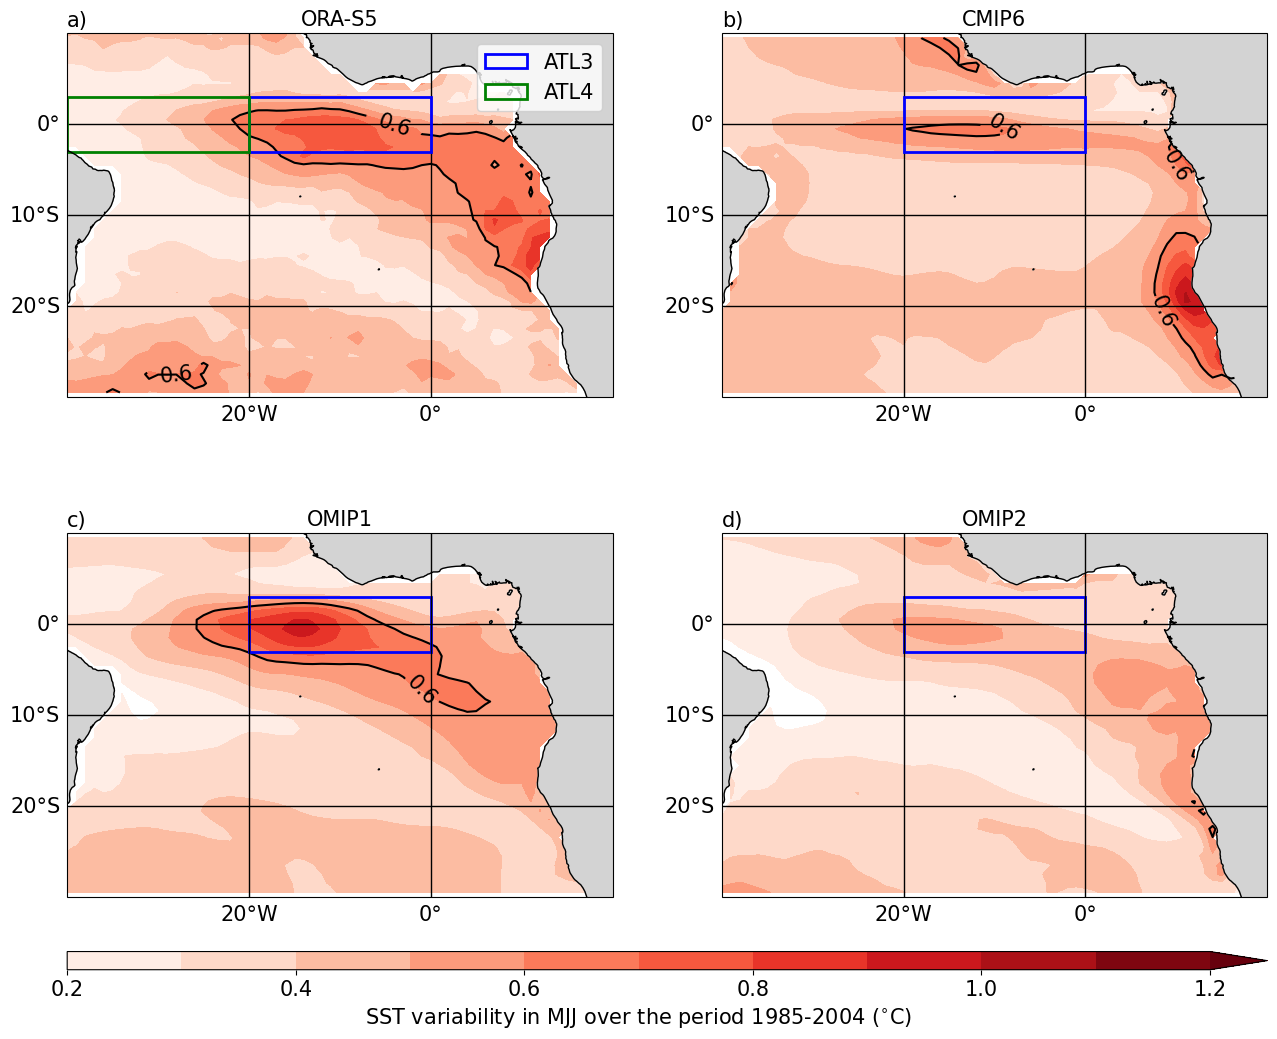

In [28]:

ftz=15
f,ax = plt.subplots(2,2,figsize=[12,10], subplot_kw={'projection': ccrs.PlateCarree()})
f.patch.set_facecolor('white')
m = np.arange(1,13,1)
ax = ax.ravel()
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0.2)
levels = np.arange(0.2,1.3,0.1)
cmap = plt.cm.Reds


levels0 = np.arange(14,30,1)
cmap0 = plt.cm.RdYlBu_r



cax0 = inset_axes(ax[2],
                 width='220%',
                 height='5%',
                 loc = 'lower left',
                 bbox_to_anchor=(0,-0.2,1,1),
                 bbox_transform=ax[2].transAxes,
                 borderpad=0)






## d) ##

p0 = ax[0].contourf(std_ssta_oras5_atl_dtd_mjj.lon,
               std_ssta_oras5_atl_dtd_mjj.lat,
               std_ssta_oras5_atl_dtd_mjj,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')



cs0 = ax[0].contour(std_ssta_oras5_atl_dtd_mjj.lon,
               std_ssta_oras5_atl_dtd_mjj.lat,
               std_ssta_oras5_atl_dtd_mjj,colors='black',
               levels=[0.6])
ax[0].clabel(cs0, cs0.levels, inline=True, fontsize=ftz)

ax[0].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3'))
ax[0].add_patch(mpatches.Rectangle(xy=[-40,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='green',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL4'))


gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[0].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[0].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[0].set_xlim([-40,20])
ax[0].set_ylim([-30,10])
ax[0].set_title('ORA-S5',fontsize=ftz)
ax[0].legend(fontsize=ftz)
cbar = plt.colorbar(p0,cax0,orientation='horizontal')
cbar.ax.tick_params(labelsize=ftz)
cbar.set_label('SST variability in MJJ over the period 1985-2004 ($^{\circ}$C)',fontsize=ftz)


## d) ##

p0 = ax[1].contourf(std_ssta_dtd_cmip6_mjj_mean.lon,
               std_ssta_dtd_cmip6_mjj_mean.lat,
               std_ssta_dtd_cmip6_mjj_mean,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')

cs0 = ax[1].contour(std_ssta_dtd_cmip6_mjj_mean.lon,
               std_ssta_dtd_cmip6_mjj_mean.lat,
               std_ssta_dtd_cmip6_mjj_mean,colors='black',
               levels=[0.6])
ax[1].clabel(cs0, cs0.levels, inline=True, fontsize=ftz)

ax[1].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3'))


gl = ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[1].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[1].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[1].set_xlim([-40,20])
ax[1].set_ylim([-30,10])
ax[1].set_title('CMIP6',fontsize=ftz)

## e) ##



ax[2].contourf(std_ssta_omip1_atl_all_mjj.lon,
               std_ssta_omip1_atl_all_mjj.lat,
               std_ssta_omip1_atl_all_mjj,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')

cs0 = ax[2].contour(std_ssta_omip1_atl_all_mjj.lon,
               std_ssta_omip1_atl_all_mjj.lat,
               std_ssta_omip1_atl_all_mjj,colors='black',
               levels=[0.6])
ax[2].clabel(cs0, cs0.levels, inline=True, fontsize=ftz)

gl = ax[2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[2].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[2].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[2].set_xlim([-40,20])
ax[2].set_ylim([-30,10])
ax[2].set_title('OMIP1',fontsize=ftz)

ax[2].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3'))

#ax[2].add_patch(mpatches.Rectangle(xy=[8,-20],
#                                   width=8,
#                                   height=10,
#                                   edgecolor='green',
#                                   fill=None,
#                                   alpha=1,linewidth=2,zorder=2,label='ABA'))



## f) ##

ax[3].contourf(std_ssta_omip2_atl_all_mjj.lon,
               std_ssta_omip2_atl_all_mjj.lat,
               std_ssta_omip2_atl_all_mjj,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')

cs0 = ax[3].contour(std_ssta_omip2_atl_all_mjj.lon,
               std_ssta_omip2_atl_all_mjj.lat,
               std_ssta_omip2_atl_all_mjj,colors='black',
               levels=[0.6])
ax[3].clabel(cs0, cs0.levels, inline=True, fontsize=ftz)

gl = ax[3].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=3)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[3].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[3].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=2)# add coastlines
ax[3].set_title('OMIP2',fontsize=ftz)
ax[3].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2))

#ax[3].add_patch(mpatches.Rectangle(xy=[8,-20],
#                                   width=8,
#                                   height=10,
#                                   edgecolor='green',
#                                   fill=None,
#                                   alpha=1,linewidth=2,zorder=2))
ax[3].set_xlim([-40,20])
ax[3].set_ylim([-30,10])

ax[0].text(0,1.02,'a)',transform=ax[0].transAxes,size=ftz)
ax[1].text(0,1.02,'b)',transform=ax[1].transAxes,size=ftz)
ax[2].text(0,1.02,'c)',transform=ax[2].transAxes,size=ftz)
ax[3].text(0,1.02,'d)',transform=ax[3].transAxes,size=ftz)
plt.savefig(path_fig+'figure_02.png',bbox_inches='tight',dpi=300)